## Results

This notebook is to help split the workstream for model fitting and analyses, evaluations, and visualizations. It should be able to load any previously fitted network, so long as the parameters were saved.

In [1]:
# imports
import os
import imp
import numpy as np
import pandas as pd
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bayes_mvs as bmvs

# settings
%matplotlib inline

sns.set_style('white')
sns.set_context('poster')
colors = sns.color_palette()

# aliases
L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor

## Data Loading

For now, we just want the data from the first experiment.

In [2]:
headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datadir = os.path.join(headdir, 'Data/model input')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')

hvhdata = loading.default_loader(os.path.join(datadir, '0 (with groups).csv'))
Xs = np.concatenate(hvhdata[2])
ys = np.concatenate(hvhdata[3])
Ss = np.concatenate(hvhdata[4])

## Analysis

In [8]:
# reproduce data
tune_results = np.zeros([40, 5, 5])
tune_results_byboard = pd.DataFrame(index=np.arange(Xs.shape[0]), columns=np.arange(25))

prototype = default_convnet
net_list = []
for i in np.arange(5):
    net = Network(prototype)
    net.load_params(os.path.join(paramsdir, '{} split agg fit exp 1-4.npz'.format(i)))
    net_list.append(net)

for i, n in enumerate(net_list):
    for j in range(5):
        params = L.get_all_param_values(n.net)  
        subnet = Network(prototype)
        subnet.load_params(os.path.join(paramsdir, '{} agg fit exp 1-4 {} tune fit exp 0.npz'.format(i, j)))
        res = subnet.itemized_test_fn(Xs, ys)
        for s in np.unique(Ss):
            idx = np.where(Ss==s)[0]
            tune_results[s, j, i] = res[idx].mean()
        tune_results_byboard[5*i+j] = res
        
print(bmvs(tune_results.mean(axis=(1,2))))

(Mean(statistic=1.8895031381739038, minmax=(1.8097881110292786, 1.969218165318529)), Variance(statistic=0.094377362595261444, minmax=(0.063987902994348825, 0.1358983989627362)), Std_dev(statistic=0.30514049970042506, minmax=(0.25295830287687499, 0.36864400030752731)))


In [10]:
tune_results_byboard['npieces'] = Xs.sum(axis=(1, 2, 3))
trbynpieces = tune_results_byboard.pivot_table(index='npieces', aggfunc=np.mean)
trout = tune_results.reshape([40, 25])
defarray = np.loadtxt(os.path.join(headdir, 'Analysis/0_hvh/Loglik/loglik_hvh_default.txt'))
defarray = defarray.reshape([40, 5, 10]).reshape([40, 50])
np.savetxt(os.path.join(resultsdir, 'loglik_by_npieces.txt'), trbynpieces.values)
np.savetxt(os.path.join(resultsdir, 'arch32 agg fit exp 1-4 agg tune fit exp 0.csv'), trout, fmt='%.18f', delimiter=',')

### Summary figure

In [11]:
histkws = {
    'alpha': .8, 'edgecolor': 'white',
    'normed': False, 'bins': np.arange(1.2, 3.0, .1)   
}

scatterkws = {
    'marker':'o', 'markersize':7, 'linestyle': 'None', 'alpha': .8
}

hmkws = {
    'cbar': False, 'cmap': sns.light_palette(colors[0], as_cmap=True),
    'square': True, 'xticklabels': False, 'yticklabels': False,
    'vmin': 0, 'vmax': 1
}

boardplotkws = {
    'marker': 'o', 'markersize': 20, 'markeredgecolor': 'black', 'markeredgewidth': 2,
    'linestyle': 'None'
}

def show_net_response(pos_idx, ax, net=subnet):
    response = net.output_fn(Xs[pos_idx:pos_idx+1, :, :, :])
    sns.heatmap(response.reshape([4, 9])[::-1, :], ax=ax, **hmkws)
    
    if Xs[pos_idx, :, :, :].sum()%2 == 0:
        b = 0
        w = 1
    else:
        b = 1
        w = 0
    
    bcoords = np.where(Xs[pos_idx, b, :, :]==1)
    wcoords = np.where(Xs[pos_idx, w, :, :]==1)
    rcoords = np.unravel_index(ys[pos_idx], (4, 9))

    ax.plot(bcoords[1]+.5, bcoords[0]+.5, color='black', **boardplotkws)
    ax.plot(wcoords[1]+.5, wcoords[0]+.5, color='white', **boardplotkws)
    ax.plot(rcoords[1]+.5, rcoords[0]+.5, color=colors[2], **boardplotkws)
    plt.setp(ax, frame_on=False)
    
    return None

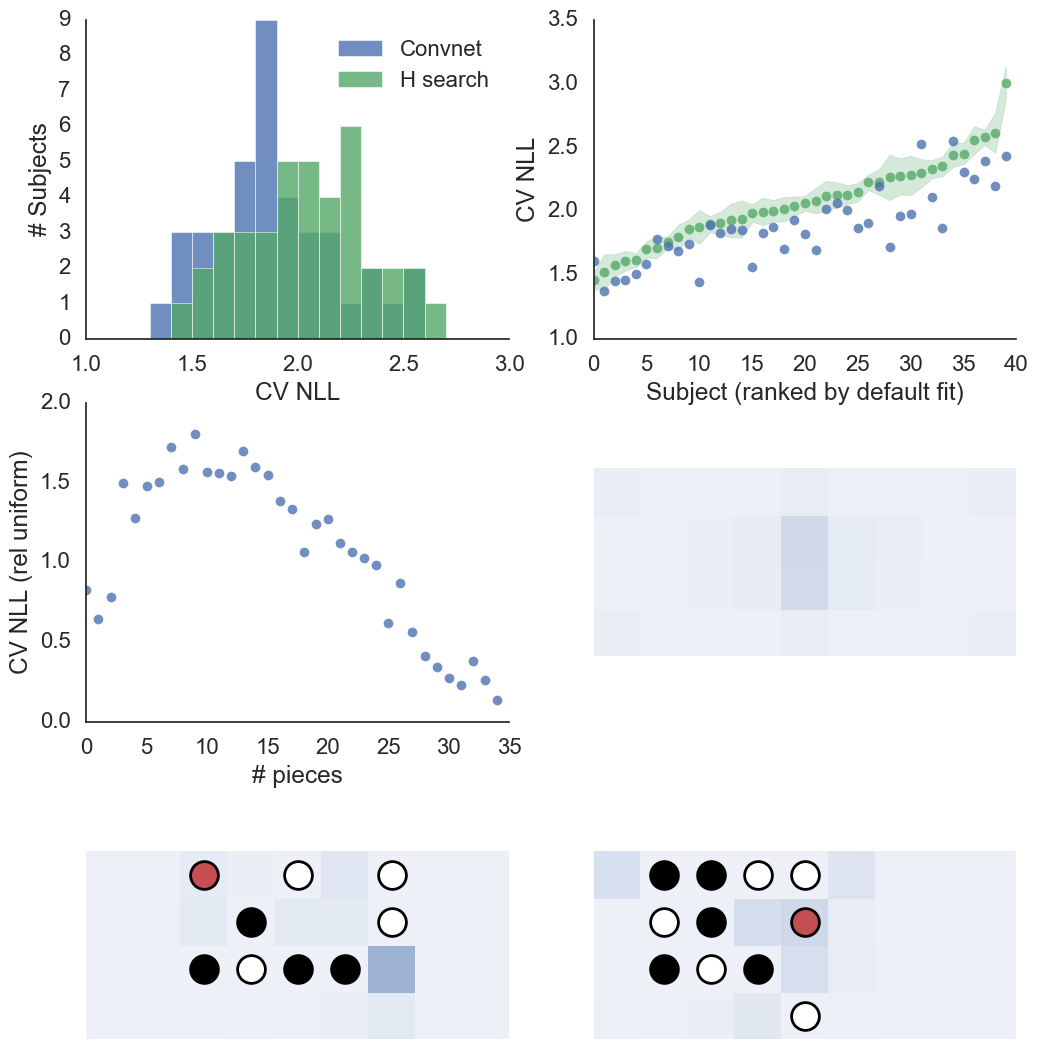

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(12, 14), squeeze=False)

ax = axes[0, 0]
ax.hist(trout.mean(axis=1), color=colors[0], label='Convnet', **histkws)
ax.hist(defarray.mean(axis=1), color=colors[1], label='H search', **histkws)
ax.legend(loc=0)
plt.setp(ax, xlabel='CV NLL', ylabel='# Subjects')


ax = axes[0, 1]
mos = [bmvs(trout[i, :], alpha=.95) for i in np.arange(40)]
means = np.array([mo[0][0] for mo in mos])
lbs = np.array([mo[0][1][0] for mo in mos])
ubs = np.array([mo[0][1][1] for mo in mos])

dmos = [bmvs(defarray[i, :], alpha=.95) for i in np.arange(40)]
dmeans = np.array([mo[0][0] for mo in dmos])
dlbs = np.array([mo[0][1][0] for mo in dmos])
dubs = np.array([mo[0][1][1] for mo in dmos])

orderidx = defarray.mean(axis=1).argsort()

ax.plot(np.arange(40), dmeans[orderidx], color=colors[1], **scatterkws)
ax.fill_between(np.arange(40), y1=dlbs[orderidx], y2=dubs[orderidx], alpha=.25, color=colors[1])
ax.plot(np.arange(40), means[orderidx], color=colors[0], **scatterkws)
plt.setp(ax, xlabel='Subject (ranked by default fit)', ylabel='CV NLL')


ax = axes[1, 0]
mos = [bmvs(trbynpieces.loc[i, :].values, alpha=.95) for i in np.arange(36)]
means = np.array([mo[0][0] for mo in mos])
lbs = np.array([mo[0][1][0] for mo in mos])
ubs = np.array([mo[0][1][1] for mo in mos])

means_corrected = -(means + np.log(1/(np.arange(36)+1)[::-1]))
ax.plot(np.arange(36), means_corrected, **scatterkws)
# ax.fill_between(np.arange(36), y1=lbs, y2=ubs)
plt.setp(ax, xlabel='# pieces', ylabel='CV NLL (rel uniform)')


ax = axes[1, 1]
blank = np.zeros([1, 2, 4, 9])
sns.heatmap(subnet.output_fn(blank).reshape([4, 9])[::-1, :], ax=ax, **hmkws)
plt.setp(ax, frame_on=False)


ax = axes[2, 0]
show_net_response(0, ax=ax)


ax = axes[2, 1]
show_net_response(12, ax=ax)


sns.despine();

### What are the filters like?

In [13]:
filter_layer = L.get_all_layers(subnet.net)[2]
filter_output = L.get_output(filter_layer, deterministic=True)
filter_output_fn = theano.function([subnet.input_var], filter_output)
filters = L.get_all_param_values(L.get_all_layers(subnet.net)[1])[0]

imshowkws = {
    'interpolation': 'nearest',
    'vmin': -.5, 'vmax': .5,
    'cmap': sns.diverging_palette(20, 240, n=15, as_cmap=True)
}

def show_filter_output(pos_idx, filter_idx=None, ax=None):
    if not ax:
        ax = plt.gca()
    
    if not (filter_idx is None):
        fout = filter_output_fn(Xs[pos_idx:pos_idx+1, :, :, :])[0, filter_idx, 1:-2, 1:-2]
    else:
        fout = filter_output_fn(Xs[pos_idx:pos_idx+1, :, :, :])[0, :, 1:-2, 1:-2].sum(axis=0)
        
    ax.imshow(fout, **imshowkws)
    plt.setp(ax, frame_on=False, xticklabels=[], yticklabels=[], xlabel='Filter response')
    
    return ax

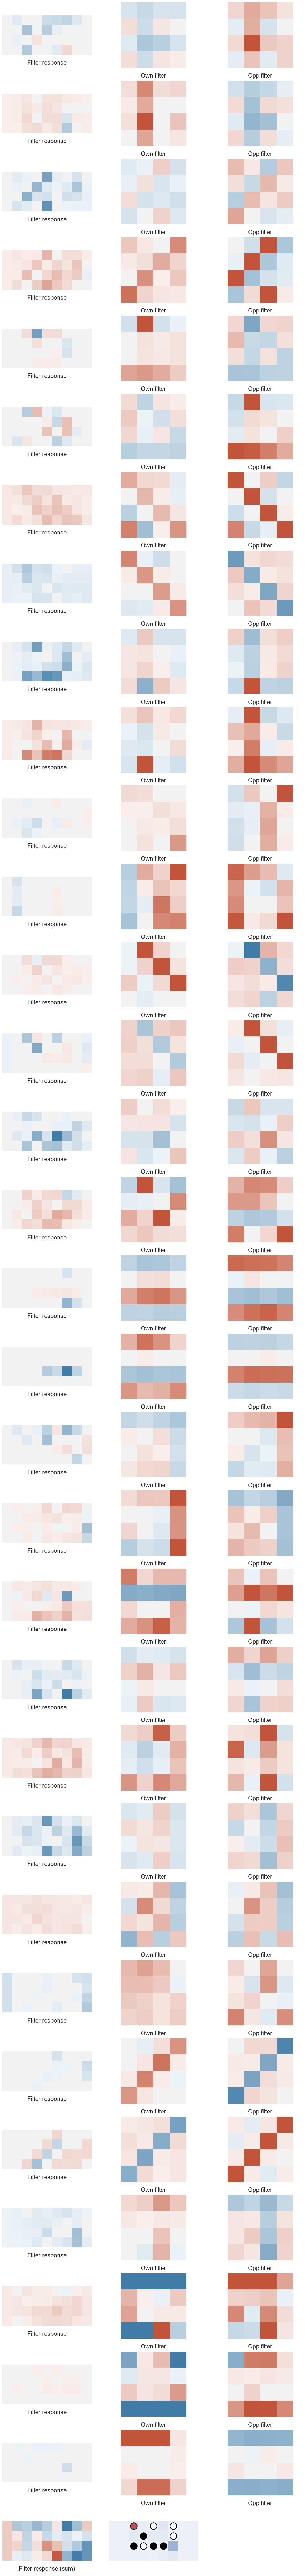

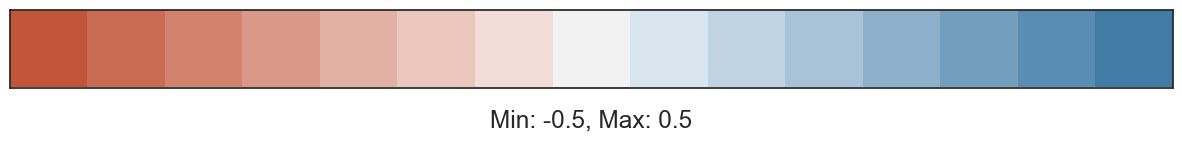

In [14]:
fig, axes = plt.subplots(33, 3, figsize=(16, 136), squeeze=False)

pos_idx = 0

for i in np.arange(32):

    
    ax = axes[i, 0]
    show_filter_output(pos_idx, filter_idx=i, ax=ax)


    ax = axes[i, 1]
    ax.imshow(filters[i, 0, :, :], **imshowkws)
    plt.setp(ax, frame_on=False, xticklabels=[], yticklabels=[], xlabel='Own filter')


    ax = axes[i , 2]
    ax.imshow(filters[i, 1, :, :], **imshowkws)
    plt.setp(ax, frame_on=False, xticklabels=[], yticklabels=[], xlabel='Opp filter')

    
ax = axes[-1, 0]
show_filter_output(pos_idx, ax=ax)
plt.setp(ax, xlabel='Filter response (sum)')


ax = axes[-1, 1]
show_net_response(pos_idx, ax=ax)


ax = axes[-1, 2]
plt.setp(ax, frame_on=False, xticklabels=[], yticklabels=[])


sns.despine()
sns.palplot(sns.diverging_palette(20, 240, n=15))
plt.setp(plt.gca(), xlabel='Min: {}, Max: {}'.format(imshowkws['vmin'], imshowkws['vmax']));